In [1]:
import os
import argparse
import importlib
import map_util
import numpy as np
import matplotlib.pyplot as plt

import shapely
from shapely.ops import split
from shapely.geometry import Polygon, LineString, Point

BASE_DIR = !git rev-parse --show-toplevel
BASE_DIR = os.path.abspath(*BASE_DIR)
print(f"BASE DIR = {BASE_DIR}")
os.chdir(BASE_DIR)

BASE DIR = /home/ps2958/pps-election


# Utility functions

In [2]:
def get_rotation_matrix(theta):
    """
    Set theta>0 for counter-clockwise rotation.
    Set theta<0 for clockwise rotation.
    Transpose rotation matrix to reverse rotation.
    """
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

In [3]:
MAP_LIST    = map_util.list_maps()
LOADED_MAPS = [map_util.load_map(map_file) for map_file in MAP_LIST]

In [4]:
def visualize_map(_map, ax=None, color_scheme='argmax'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
    
    if color_scheme == 'argmax':
        colors = np.argmax(_map[:, 2:], 1)
    else:
        colors = [tuple(dist) for dist in _map[:, 2:]]

    plot = ax.scatter(_map[:,0], _map[:,1], s=0.01, c=colors, alpha=0.5, cmap='rainbow')

In [6]:
def heuristic_function(ratio1, ratio2, target):
    # Heavy penalty for a loss
    delta  = ((ratio1<0.50) + (ratio2<0.50)) * 10
    
    # Penalties for differences to target
    delta += ((ratio1<target) + 1) * np.abs(ratio1-target)
    delta += ((ratio2<target) + 1) * np.abs(ratio2-target)
    
    return delta

In [57]:
def find_two_split(location, winners, split_ratio=3, resolution=315, MYPARTY=0, return_top=True):
    """ Given a polygon, split it in 3 """
    
    target = (winners==MYPARTY).mean()
    if target < 0.5: print("Cannot handle < 0.5 ")
    
    thetas = np.linspace(0, np.pi, resolution)
    deltas = np.full_like(thetas, np.nan)
    ratios1 = np.zeros_like(thetas)
    ratios2 = np.zeros_like(thetas)
    
    for i, theta in enumerate(thetas):
        R = get_rotation_matrix(theta)
        new_locs = location @ R.T
        
        # Since we're rotating a full 360, a line x=x* will result
        # in all possible separations with a single line
        sortidx = new_locs[:, 0].argsort()
        d1_idxs = sortidx[:len(sortidx)//split_ratio]
        
        ratio1 = (winners[d1_idxs]==MYPARTY).mean()
        ratio2 = (np.delete(winners, d1_idxs, 0)==MYPARTY).mean()
        
        delta  = heuristic_function(ratio1, ratio2, target)
        
        deltas[i]  = delta
        ratios1[i] = ratio1
        ratios2[i] = ratio2
    
    if return_top:
        min_idx = deltas.argmin()
        print(f"Found delta : {deltas.min():0.5f} at theta {thetas[min_idx]:0.5f}. Split=[{ratios1[min_idx]:0.3f} {ratios2[min_idx]:0.3f}]")
        return thetas[min_idx]
    
    delta_idx = deltas.argsort()[:10]
    return thetas[delta_idx], deltas[delta_idx], ratios1[delta_idx], ratios2[delta_idx]

In [62]:
def recursively_split_threes(location, winners, polygon, num_splits=5, resolution=1000, MYPARTY=0):
    """
    Splits a district into three with equal populations but same proportion of voters.
    
    First splits it into 1/3 and 2/3, then subdivides the 2/3 into halves.
    Generation of (theta1, theta2) is done independently rather than in O(n^2)
    """
    if num_splits == 0:
        return [polygon]
    
    print("Target = ", (winners==MYPARTY).mean())
    
    thetas, deltas, ratio1, ratio2 = find_two_split(location, winners, split_ratio=3, resolution=resolution, MYPARTY=MYPARTY, return_top=False)
    
    # Find second theta, given first theta to minimize overall delta
    # Increases overall runtime from O(n) to O(n^2) but also improves performance
    best_theta1, best_theta2, best_delta = None, None, np.inf
    
    for theta, delta in zip(thetas, deltas):
        print(theta, end=" ")
        polyA, polyB, idxesA = split_polygon(location, theta, polygon, split_ratio=3)
        locationB, winnersB  = np.delete(location, idxesA, 0), np.delete(winners, idxesA, 0)
        
        thetas2, deltas2, _, _ = find_two_split(locationB, winnersB, split_ratio=3, resolution=resolution, MYPARTY=MYPARTY, return_top=False)
        
        if delta + deltas2[0] < best_delta:
            best_delta = delta + deltas2[0]
            best_theta1, best_theta2 = theta, thetas2[0]
    print()
    poly1, polyB, idxesA = split_polygon(location, best_theta1, polygon, split_ratio=3)
    location1, winners1  = location[idxesA], winners[idxesA]
    locationB, winnersB  = np.delete(location, idxesA, 0), np.delete(winners, idxesA, 0)
    
    poly2, poly3, idxesB = split_polygon(locationB, best_theta2, polyB, split_ratio=3)
    location2, winners2  = locationB[idxesB], winnersB[idxesB]
    location3, winners3  = np.delete(locationB, idxesB, 0), np.delete(winnersB, idxesB, 0)
    
    print(f"{num_splits} Found split Δ={best_delta} splits={[(winners1==MYPARTY).mean(), (winners2==MYPARTY).mean(), (winners3==MYPARTY).mean()]}")
    
    threesA = recursively_split_threes(location1, winners1, poly1, num_splits-1, resolution, MYPARTY)
    threesB = recursively_split_threes(location2, winners2, poly2, num_splits-1, resolution, MYPARTY)
    threesC = recursively_split_threes(location3, winners3, poly3, num_splits-1, resolution, MYPARTY)
    
    return threesA + threesB + threesC

In [72]:
def recursively_split_twos(location, winners, polygon, num_splits=8, resolution=1000, MYPARTY=0):
    """
    Splits a district into two equal halves with same proportion with a penalty for < 0.50
    Outperforms recursively_split_threes
    """
    if num_splits==0:
        return [polygon]
    
    print()
    theta = find_two_split(location, winners, split_ratio=2, resolution=resolution, MYPARTY=MYPARTY)
    poly1, poly2, idxes = split_polygon(location, theta, polygon)

    location1, winners1 = location[idxes], winners[idxes]
    location2, winners2 = np.delete(location, idxes, 0), np.delete(winners, idxes, 0)
    
    left_polygons  = recursively_split_twos(location1, winners1, poly1, num_splits-1, resolution, MYPARTY)
    right_polygons = recursively_split_twos(location2, winners2, poly2, num_splits-1, resolution, MYPARTY)
    
    return left_polygons + right_polygons

In [22]:
def split_polygon(location, theta, polygon, split_ratio=2):
    """
    Helper function.
    Given a polygon and a theta, divides the polygon into two districts based on theta
    """
    R = get_rotation_matrix(theta)
    new_locs = location @ R.T
    
    sorted_idx  = new_locs[:, 0].argsort()
    sorted_locs = new_locs[sorted_idx]
    
    low_loc  = sorted_locs[len(sorted_idx)//split_ratio]
    high_loc = sorted_locs[len(sorted_idx)//split_ratio + 1]
    xp, yp   = (low_loc + high_loc) / 2
    
    rp = Polygon(np.dstack(polygon.exterior.xy)[0] @ R.T)
    x_min, y_min, x_max, y_max = rp.bounds
    
    """ Has form x = xp """
    liney = LineString([[xp, y_min], [xp, y_max]] @ R)

    poly1, poly2 = shapely.ops.split(polygon, liney)
    containing_idxs = [i for i, loc in enumerate(location) if poly1.contains(Point(*loc))]
    
    return poly1, poly2, containing_idxs

# District generation code

[173097 160236]


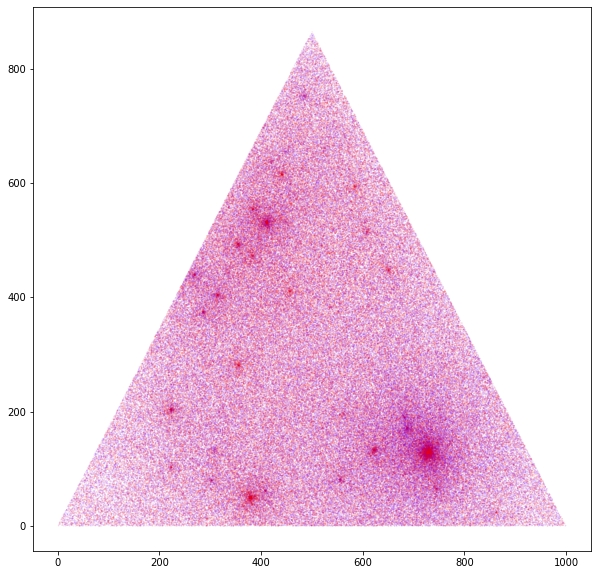

In [75]:
mmap = LOADED_MAPS[2]
visualize_map(mmap)

print(np.bincount(mmap[:,2:].argmax(1)))

In [69]:
# Code to generate 243 districts with 1 elector scheme
location, winners = mmap[:,:2], mmap[:,2:].argmax(1)
polygon   = Polygon([[0,0], [1000,0], [500,500*np.sqrt(3)]])

districts = recursively_split_threes(location, winners, polygon, num_splits=5, resolution=1000, MYPARTY=0)

Target =  0.5192915192915193
2.4686188519199073 2.4717635893108882 2.4654741145289267 2.4749083267018688 2.4780530640928498 2.4623293771379458 2.4811978014838303 2.4843425388748113 2.459184639746965 2.487487276265792 
5 Found split Δ=0.0005238147991044606 splits=[0.5192848560667084, 0.5194130194130194, 0.5190885036989038]
Target =  0.5192848560667084
2.305092507588907 2.3019477701979265 2.308237244979888 2.2988030328069455 2.295658295415965 2.3113819823708686 2.3145267197618495 2.292513558024984 2.31767145715283 2.320816194543811 
4 Found split Δ=7.485786050021037e-05 splits=[0.5193185193185194, 0.519258029241424, 0.519288014093919]
Target =  0.5193185193185194
2.415158316273234 2.412013578882253 2.418303053664215 2.4088688414912727 2.4214477910551957 2.4057241041002917 2.4245925284461767 2.427737265837157 2.402579366709311 2.4340267406191187 
3 Found split Δ=0.0011617864325613736 splits=[0.5190750040498947, 0.51916651479254, 0.5195771695878011]
Target =  0.5190750040498947
2.456039902

In [ ]:
# Code to generate 256 districts with 1 elector scheme
location, winners = mmap[:,:2], mmap[:,2:].argmax(1)
polygon   = Polygon([[0,0], [1000,0], [500,500*np.sqrt(3)]])

districts = recursively_split_twos(location, winners, polygon, num_splits=8, MYPARTY=0)


Found delta : 0.00015 at theta 2.33968. Split=[0.519 0.519]

Found delta : 0.00016 at theta 2.12270. Split=[0.519 0.519]

Found delta : 0.00011 at theta 2.23591. Split=[0.519 0.519]

Found delta : 0.00072 at theta 2.29251. Split=[0.519 0.520]

Found delta : 0.00309 at theta 2.31767. Split=[0.518 0.520]

Found delta : 0.00662 at theta 2.33025. Split=[0.516 0.520]

Found delta : 0.00058 at theta 2.33340. Split=[0.516 0.516]

Found delta : 0.00460 at theta 2.33654. Split=[0.514 0.517]

Found delta : 0.00576 at theta 2.33025. Split=[0.514 0.518]

Found delta : 0.00346 at theta 2.32082. Split=[0.519 0.522]

Found delta : 0.00516 at theta 2.32711. Split=[0.518 0.521]

Found delta : 0.00055 at theta 2.32082. Split=[0.521 0.522]

Found delta : 0.00187 at theta 2.30509. Split=[0.520 0.521]

Found delta : 0.01583 at theta 2.31453. Split=[0.514 0.525]

Found delta : 0.00290 at theta 2.31453. Split=[0.515 0.513]

Found delta : 0.02995 at theta 2.30824. Split=[0.515 0.535]

Found delta : 0.00058 a

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

colors  = winners
plot = ax.scatter(*location.T, s=0.01, c=winners, alpha=0.5, cmap='rainbow')

for district in districts:
    plt.plot(*district.exterior.xy)

# Save to dat file

In [ ]:
num_voters, num_parties = 333333, 2

district_boundaries = [
    [len(district.boundary.coords)] + [p for x in district.boundary.coords for p in x] 
    for district in districts
]
num_districts = len(district_boundaries)

fmt_boundary = []
for boundary in district_boundaries:
    fmt_boundary.append(str(boundary[0]) + " " + "".join(map(lambda x:f"{x:f} ", boundary[1:])))

with open(f"tmp_turkey.dat", "w") as handle:
    np.savetxt(handle, mmap, fmt="%f", delimiter=' ', header=f"{num_voters} {num_parties}", comments='')
    np.savetxt(handle, np.array(fmt_boundary), fmt="%s", header=f"{num_districts}", comments='')